# HCI Week 2 - The disk around Beta Pictoris
*Matthew Kenworthy // Leiden Observatory*


You will analyse coronagraphic data of Beta Pictoris and investigate which one of three methods gives the clearest signal for the disk.


Two images were taken - one of beta Pic and one of a nearby reference star aligned behind the coronagraph. *Data reproduced here by kind permission of Paul Kalas. Observation date 10 October 1993. PSF reference star is HR 919.*

**REMEMBER** that coordinates in `numpy` arrays are transposed, so that point $(x,y)$ is at `[y,x]`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import rotate
import os
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def zoom(im,x,y,bb):
    '''returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def rotate2(img, angle, c_in):
    '''rotate input image img by angle degrees about a point c_in
    c_in is an np.array((y,x))
    returns the rotated image with zeroes for unknown values'''
    from scipy.ndimage.interpolation import affine_transform
    a=angle*np.pi/180.0
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    offset=c_in-c_in.dot(transform)
    dst=affine_transform(img,transform.T,order=2,offset=offset,output_shape=(img.shape),cval=0.0)
    return(dst)

#Creating folders to save images
os.system("mkdir TopHat_Smoothing")
os.system("mkdir Rings")
os.system("mkdir Reference_Star")

0


Open the images in `ds9` and determine the location of beta Pictoris and write down the coordinates in `xcen` and `ycen`.

**Q1 (2 points):** Show that you have the right location for the star by displaying the image with a box of 40 pixels width centered on the star.



In [2]:
# loading in the images into the Notebook.

pic1, pic1_header = fits.getdata("beta_pic_kalas_1995/pic1.fits", header=True)
ref1, ref1_header = fits.getdata("beta_pic_kalas_1995/hr9.1.fits", header=True)

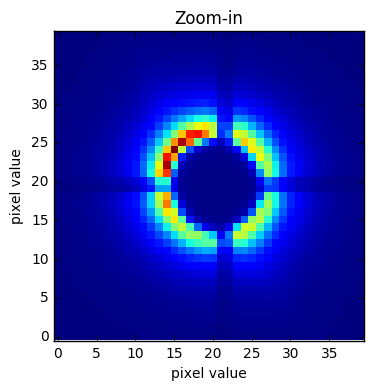

In [3]:
# visually determine the center of beta pic by examining the image in DS9

# The center for beta pic is at (261.97, 198.08) so in python 261 and 197. 

Beta_Location = zoom(pic1, 261, 197, 20)
plt.imshow(Beta_Location)
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Zoom-in')

**Q2 (4 points):** Select a sky background region of 50 by 50 pixels that has no defects or stars in it. Display the region using `imshow()`. Determine background noise using `np.mean()` and `np.std()`. Print out both values to 2 significant figures using the `print()` command and the Pythonic [formatters detailed on this page](https://www.python-course.eu/python3_formatted_output.php).


Mean_right = 0.10 , STD_right = 0.25
Mean_left = 0.12 , STD_left = 0.25


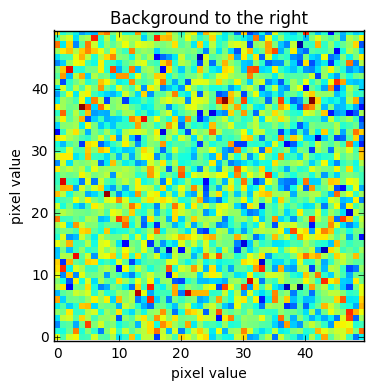

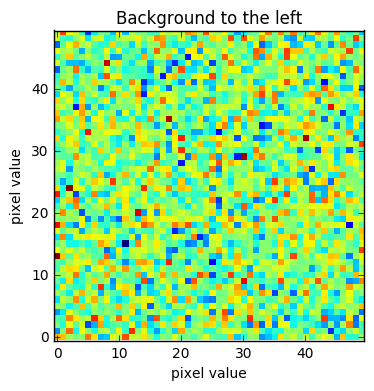

In [4]:
# Region of 50x50 pixels checked with DS9, centered at (113, 124) so (112, 123)
# Region of 50x50 pixels checked with DS9, centered at (419, 74) so (418, 73)
# We print out two diferent values of mean and standard deviation for the same image
# with a background aperture to the right and another one to the left.

print("")

plt.figure()
Background_right = zoom(pic1, 112, 123, 25)
print("Mean_right = %.2f , STD_right = %.2f"%(np.mean(Background_right), np.std(Background_right)))
plt.imshow(Background_right)
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Background to the right')

plt.figure()
Background_left = zoom(pic1, 418, 73, 25)
print("Mean_left = %.2f , STD_left = %.2f"%(np.mean(Background_left), np.std(Background_left)))
plt.imshow(Background_left)
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Background to the left')

## Method 1: Unsharp masking with Top Hat Kernel

Read the `astropy` documents on [convolution](http://astropy.readthedocs.org/en/latest/convolution/) and [kernels](http://astropy.readthedocs.org/en/latest/convolution/kernels.html). 

**Q3 (5 points):** Using the `circle_mask()` routine you wrote last week, make a square image 11 pixels on a side that contains a circle 11 pixels in diameter. Normalise the total flux in the image to 1. This will be your **Top Hat smoothing kernel**. 

Note that you can also do this with `Tophat2DKernel` below. Convolve the Beta Pic image with this kernel to produce an image that only follows the low spatial frequencies. Subtract this image off the original Beta Pic image, write it out to a FITS file, and look at it in DS9.



0

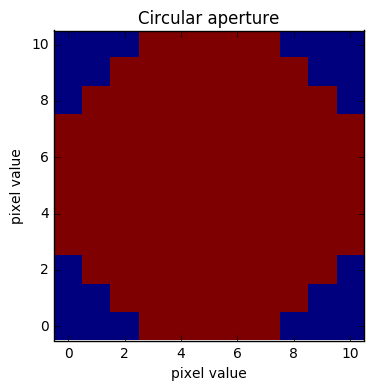

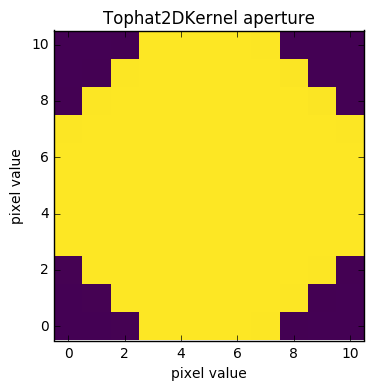

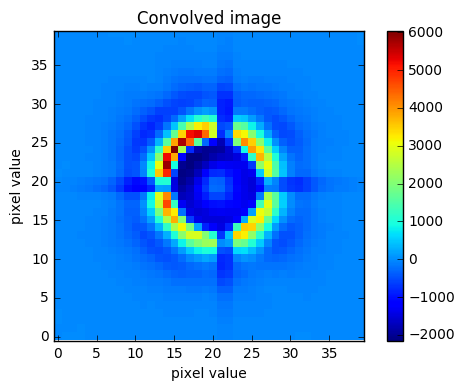

In [5]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel

# Making the 11 pixels squared image containing the circle
def Arbitrary_circle(im, xc, yc, R):
    ny,nx = im.shape
    y,x   = np.mgrid[0:ny,0:nx]
    return (x - xc)**2 + (y - yc)**2 < R**2

# Printing out the mask created with our cirlce aperture
plt.figure()
Mask = Arbitrary_circle(np.zeros((11,11)), 5, 5, 5.5)
#print Mask.astype(int)
plt.imshow(Mask)
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Circular aperture')

# Printing out the mask created with the Tophat2DKernel
plt.figure()
Kernel = Tophat2DKernel(5.5)
plt.imshow(Kernel, interpolation='none', origin='lower', cmap = 'viridis')
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Tophat2DKernel aperture')

# Performing the convolution of betapic with the top hat smoothing kernel
# Subtracting the smoothed kernel
plt.figure()
Smoothed_data_gauss = convolve(pic1, Kernel)
New_pic1 = pic1 - Smoothed_data_gauss
plt.imshow(zoom(New_pic1, 261, 197, 20))
plt.colorbar()
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Convolved image')

filename = 'TopHat_smoothing.fits'
hdu = fits.PrimaryHDU(New_pic1)
hdu.writeto(filename, overwrite=True)
os.system("mv TopHat_smoothing.fits TopHat_Smoothing/")

## Unsharp Masking with Gaussian Kernel
Now carry out the unsharp masking with the Gaussian Kernel in `Gaussian2DKernel()`. Try different values for the sigma of the convolution kernel from 5 to 0.5, writing out the unsharp masked image first and examining it with ds9. 

**Q4 (2 points):** What happens to the disk and the halo for different values of the Kernel width?

In [6]:
# Masking with the Gaussian Kernel in Gaussian2DKernel()

values = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5]
for i in range(len(values)):
    
    Kernel_2 = Gaussian2DKernel(values[i])
    #plt.imshow(Kernel_2, interpolation='none', origin='lower')

    Smoothed_data_gauss_2 = convolve(pic1, Kernel_2)
    New_pic1 = pic1 - Smoothed_data_gauss_2
#plt.imshow(zoom(New_pic1, 261, 197, 20))
#plt.colorbar()

    filename = 'Gaussian_Kernel_%g.fits'%(values[i])
    hdu = fits.PrimaryHDU(New_pic1)
    hdu.writeto(filename, overwrite=True)

    # Varying the sigma value of the convolution from 5 to 0.5 with a 0.5 step shows that
    # going to small values the halo gets smaller while the disk dims. 
    # Higher values show a more extended halo and more notorious disk and the other way around. 
    
os.system("mv Gaussian_Kernel* TopHat_Smoothing/")    

0

## Method 2: Subtracting azimuthal averages
Here we take a set of concentric rings centered on beta Pic, calculate the mean value in the ring, and subtract it off the beta Pictoris image.

In the routing `r_theta` below, we generate an image with radial distance `r` and angle from the x-axis `\phi` that we can use to make more masks.

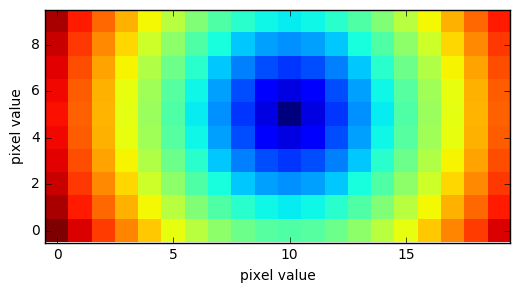

In [7]:

# make circular rings

def r_theta(im, xc, yc):
    '''make a radius mask'''
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

# show what it produces with a demonstration image

im1 = np.zeros((10,20))
r,t = r_theta(im1, 10,5)

plt.imshow(r)
plt.xlabel('pixel value')
plt.ylabel('pixel value')

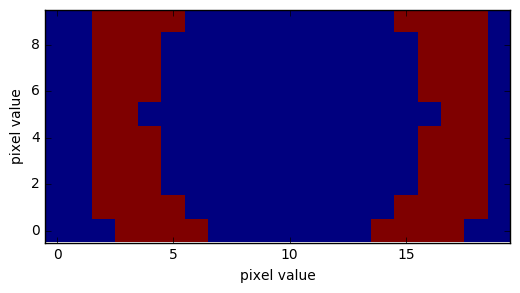

In [8]:
mask = (r > 6) * (r < 9)
plt.imshow(mask)
#mask.astype(int)
plt.xlabel('pixel value')
plt.ylabel('pixel value')

We can now make a routine that makes several concentric rings in one mask image, and can then use this as a mask for selecting successively larger rings in each image of beta Pictoris. An example of the output is shown below. Look at the `for` loop in the routine, and look at how `enumerate()` generates index values in `i`.

**NOTE** there is a way to generate this image *without* using a `for` loop...

[  5.  15.  25.  35.  45.]
5


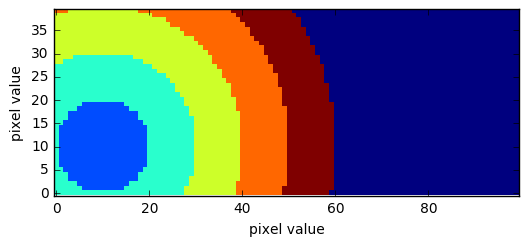

In [9]:
im2 = np.zeros((40,100))

def rings(im, x, y, r_rings):
    # makes a mask for rings of different radii specified in r_rings
    # and centre (x,y)
    # invalid values are -1
    # first, second, third... ring has value (0, 1, 2, ....)
    # ring 0 is from r_rings[0] to r_rings[1]
    # ring 1 is from r_rings[1] to r_rings[2]
    im_rings = np.zeros_like(im) - 1.
    
    # make r_inner and r_outer
    r_inner = r_rings[0:-1]
    r_outer = r_rings[1:]
    
    r, t = r_theta(im_rings, x, y)
    for i, (rin, rout) in enumerate(zip(r_inner,r_outer)):
        im_rings[(r >= rin) * (r < rout)] = i


    r_middle = (r_inner + r_outer) / 2.
    return(im_rings, r_middle)

r_rings = np.array([0,10,20,30,40,50]) # 6 points, 5 bins

im_rin, r_radius = rings(im2,10,10, r_rings)
# test that rings are complete and complementary
plt.imshow(im_rin)
plt.xlabel('pixel value')
plt.ylabel('pixel value')

print (r_radius)

nbins = r_radius.size
print (nbins)

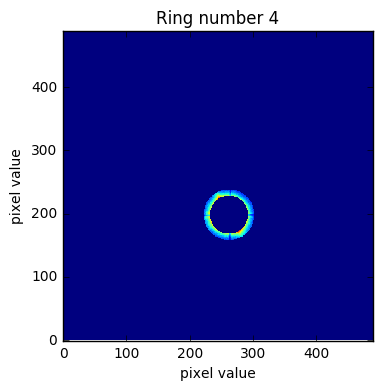

In [10]:
r_rings = np.array([0,10,20,30,40,50]) # 6 points, 5 bins

xcen = 261
ycen = 197

im_rings, r_radius = rings(pic1, xcen, ycen, r_rings)

# take mean, median and subtract off from 0 to 20 arcsec

r_mean = np.zeros_like(r_radius)
r_rms  = np.zeros_like(r_radius)

# copy ring 4 to blank image

im_test = np.zeros_like(pic1)
im_test[(im_rings == 3)] = pic1[(im_rings == 3)]

plt.imshow(im_test)
plt.xlabel('pixel value')
plt.ylabel('pixel value')
plt.title('Ring number 4')

** Q5 (6 points):** Make a set of rings using `np.linspace()` with radii from 0 to 200. Vary the number of rings from 10 to 100, and then subtract off the `mean()` of each ring to produce an output image that you can examine with `ds9`.

In [11]:
# Set of rings from 0 to 200 in pixels. 

xcen_1 = 261
ycen_1 = 197
for k in range(0,10):
    Rings_num = 10*(k + 1) + 1 # 10(k + 1) + 1 because the the first ring is from 0 to 1.
    Set_of_Rings = np.linspace(0, 200, Rings_num)  
    im_rings_1, r_radius_1 = rings(pic1, xcen_1, ycen_1, Set_of_Rings)
    r_mean_1 = np.zeros_like(im_rings_1)  
    
    for j in range(Rings_num):
        Ring_Mean = np.mean(pic1[(im_rings_1 == j)])
        r_mean_1[(im_rings_1 == j)]  = Ring_Mean
    
    New_BetaPic = pic1 - r_mean_1

    filename = 'Rings_subtract_%d.fits'%(Rings_num - 1)
    hdu = fits.PrimaryHDU(New_BetaPic)
    hdu.writeto(filename, clobber=True)
os.system("mv Rings_subtract* Rings")    

/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/local/lib64/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0

## Method 3: Subtract off a reference star

We load in another image of a nearby refence star with no disk around it, scale it and subtract it off. The exposure time of the reference star and its brightness may not be the same as that of beta Pictoris, so you will have to experiment to get the right scaling factor.


**Q6 (2 points):** Find the best scaling factor, according to your best judgement.

In [12]:
# Subtracting the reference star
# The scaling factor was computed taking into account the ratio between 
# the different counts in a circular aperture centered on the star and beta pic
# divided by its exposure time. However, as we do not really know the real brightness
# of both sources we vary this value between the one obtained without weighting by the 
# exposure time and with weghting to produce a few images and check the best one. 

Betapic_zoom = Arbitrary_circle(pic1, 261, 197, 60)
Reference_zoom = Arbitrary_circle(ref1, 261, 197, 60)
Flux_Betapic = np.sum(pic1[Betapic_zoom])
Flux_Ref = np.sum(ref1[Reference_zoom])

#print Flux_Betapic, Flux_Ref
Scaling_1 = (Flux_Betapic/2.0) / (Flux_Ref/5.0)
Scaling_2 = (Flux_Betapic) / (Flux_Ref)
#print Scaling_1, Scaling_2

Scaling_3 = np.linspace(Scaling_1, Scaling_2, 10)

for i in range(len(Scaling_3)):
    Beta_Subtracted = pic1 - i*ref1

    filename = 'Subtract_%g.fits'%(Scaling_3[i])
    hdu = fits.PrimaryHDU(Beta_Subtracted)
    hdu.writeto(filename, overwrite=True)
os.system("mv Subtract_* Reference_Star/")    

0

## Displaying your best image of the Beta Pic disk

Display one of the three methods you have tested today, in a box that is about 200 pixels wide and set the image colour range from -5 to +10.

Rotate the image of beta Pictoris so that the disk is horiztontal, and label the plot in units of Astronomical Units. **HINT** look at the options for `imshow()` that include `extent` and `vmin` and `vmax`.

**Q7 (3 points):** What is the greatest extent of the disk in AU?

Are both sides of the disk the same size?

At what inner radius (in AU) would you *trust* the data? **HINT** where do the PSF removal residuals dominate?


(-200, 200)

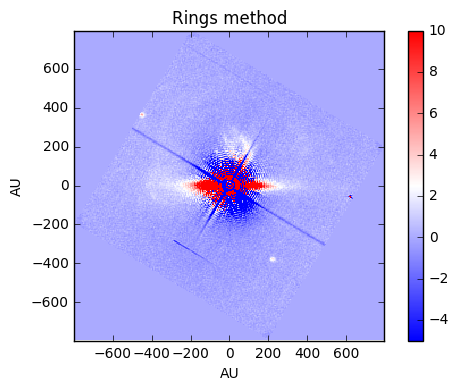

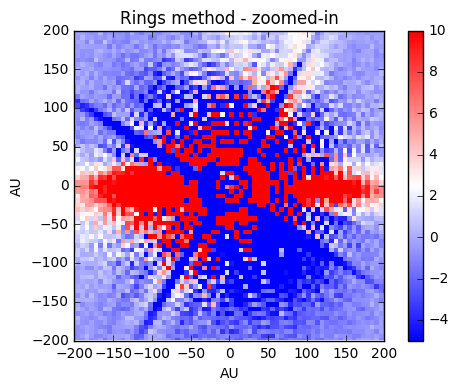

In [13]:
# North should be up, east left, pixel scale 0.41”/pix.
pscale = 0.41 # arcsec/pixel
dist   = 19.44 # parsecs

I1, I1_header = fits.getdata("TopHat_Smoothing/Gaussian_Kernel_5.fits", header=True)
I2, I2_header = fits.getdata("Rings/Rings_subtract_100.fits", header=True)
I3, I3_header = fits.getdata("Reference_Star/Subtract_3.54612.fits", header=True)

Real_size = dist*np.tan(0.41*np.pi/648000)*206265
MIN = -100*Real_size
MAX = 100*Real_size

plt.figure()
plt.imshow(rotate(zoom(I2, 261, 197, 100), 121), extent = (MIN, MAX, MIN, MAX), vmin = -5, vmax = 10, cmap ='bwr')
plt.colorbar()
plt.xlabel('AU')
plt.ylabel('AU')
plt.title('Rings method')
plt.xlim(MIN,MAX)
plt.ylim(MIN,MAX)

# Zoom to the center
plt.figure()
plt.imshow(rotate(zoom(I2, 261, 197, 100), 121), extent = (MIN, MAX, MIN, MAX), vmin = -5, vmax = 10, cmap ='bwr')
plt.colorbar()
plt.xlabel('AU')
plt.ylabel('AU')
plt.title('Rings method - zoomed-in')
plt.xlim(-200,200)
plt.ylim(-200,200)

The greatest extend of the disk is around 400AU as can be seen from the last figure. However, we can notice that the left side seems brighter and fluffy. Also an inner structure can be noticed. 

Both sides have different size. The left size looks more extended than the right side. 

The PSF removal residuals dominate at the center so we can trust the data beyond an inner radius of 80-100 AU.